In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import os
import torch
import joblib
import numpy as np

# 自定义模块
from TransformerModel import TimeSeriesTransformer
from LSTMModel import TimeSeriesLSTM
from Blender import MLPBlender
from Util import create_sequences, sample_dataset, plot_metric, plot_multiple_curves, grid_search, safe_inverse_transform, split_time_series

# 其他库
from torch.utils.data import random_split, TensorDataset
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [5]:
# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# 准备数据
df_complete = pd.read_csv ('../TockFormerData\SPY_2020-01-01_2025-05-03_60m.csv')

# 先把数据分成3份再create sequence，这样scale才不会泄漏
df_train, df_val, df_test = split_time_series(df_complete, 0.9, 0.05, 0.05)

In [7]:
target_cols = ['open', 'high', 'low', 'close']
seq_length = 32

# 创建序列
X_train, y_train, scaler, target_indices = create_sequences(df_train, seq_length=seq_length, target_cols=target_cols, scale=True)
X_val, y_val, _, _ = create_sequences(df_val, seq_length=seq_length, target_cols=target_cols, scaler=scaler)
X_test, y_test, _, _ = create_sequences(df_test, seq_length=seq_length, target_cols=target_cols, scaler=scaler)

数据被缩放
数据被缩放
数据被缩放


In [8]:
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [9]:
# 检查数据集大小
print (f"Train dataset size: {len(train_dataset)}")
print (f"Test dataset size: {len(test_dataset)}")
print (f"Val dataset size: {len(val_dataset)}")

Train dataset size: 19187
Test dataset size: 1037
Val dataset size: 1035


In [8]:
# 定义网格搜索 时序Transformer，找最好的超参数
# 固定的初始化参数
init_args = {
    'input_dim': 49,
    'output_dim': 4,
    'seq_length': 32,
    'dropout': 0.1
}

# 架构超参数空间
param_grid = {
    'model_dim': [64, 128],
    'num_heads': [2, 4],
    'num_layers': [2, 3]
}

best_params, best_score = grid_search (
    TimeSeriesTransformer,
    init_args,
    sample_dataset(train_dataset, 0.1),
    param_grid,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params)
print ('Best avg CV MSE:', best_score)

Testing architecture params: {'model_dim': 64, 'num_heads': 2, 'num_layers': 2}
=== Fold 1/3 ===
Using device: cuda
Early stopping triggered at epoch 21. Reverting to best model parameters.
=== Fold 2/3 ===
Using device: cuda
Early stopping triggered at epoch 22. Reverting to best model parameters.
=== Fold 3/3 ===
Using device: cuda
Early stopping triggered at epoch 14. Reverting to best model parameters.
 Avg CV MSE: 33.357126, Avg R2: 0.9926400432984034 

Testing architecture params: {'model_dim': 64, 'num_heads': 2, 'num_layers': 3}
=== Fold 1/3 ===
Using device: cuda
Early stopping triggered at epoch 21. Reverting to best model parameters.
=== Fold 2/3 ===
Using device: cuda
Early stopping triggered at epoch 16. Reverting to best model parameters.
=== Fold 3/3 ===
Using device: cuda
Early stopping triggered at epoch 21. Reverting to best model parameters.
 Avg CV MSE: 55.801321, Avg R2: 0.9875168800354004 

Testing architecture params: {'model_dim': 64, 'num_heads': 4, 'num_layers

In [10]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_tock = {
 'model_dim': 64,
 'num_heads': 2,
 'num_layers': 2,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1
 }


best_params_tock

{'model_dim': 64,
 'num_heads': 2,
 'num_layers': 2,
 'input_dim': 49,
 'output_dim': 4,
 'seq_length': 32,
 'dropout': 0.1}

Using device: cuda
Epoch 1: Bad batch threshold reached at batch 203. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 386. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 441. Reshuffling training data.
Epoch 1: Bad batch threshold reached at batch 555. Reshuffling training data.
Epoch 1/50, Train Loss: 0.008182
Epoch 1/50, Val MSEs: [1110.1436767578125, 2206.457275390625, 1405.0614013671875, 1043.1199951171875], R²: [-9.69132137298584, -20.771038055419922, -12.124407768249512, -9.002490997314453]
Epoch 2: Bad batch threshold reached at batch 55. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 105. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 155. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 205. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 273. Reshuffling training data.
Epoch 2: Bad batch threshold reached at batch 323. Reshuff

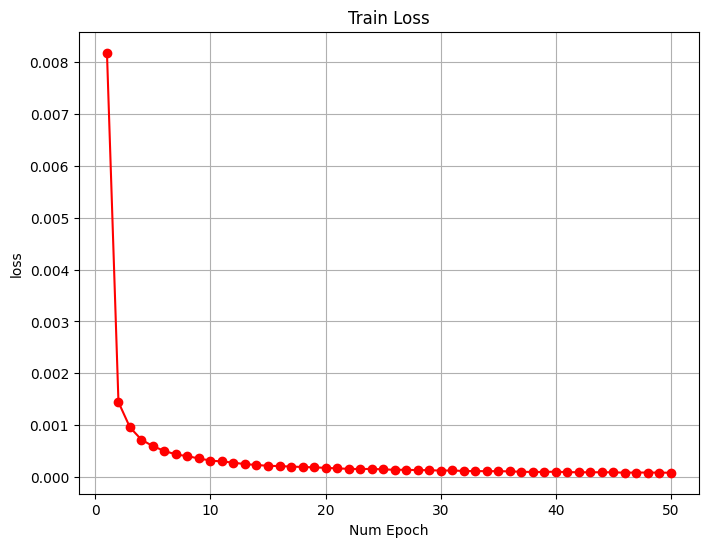

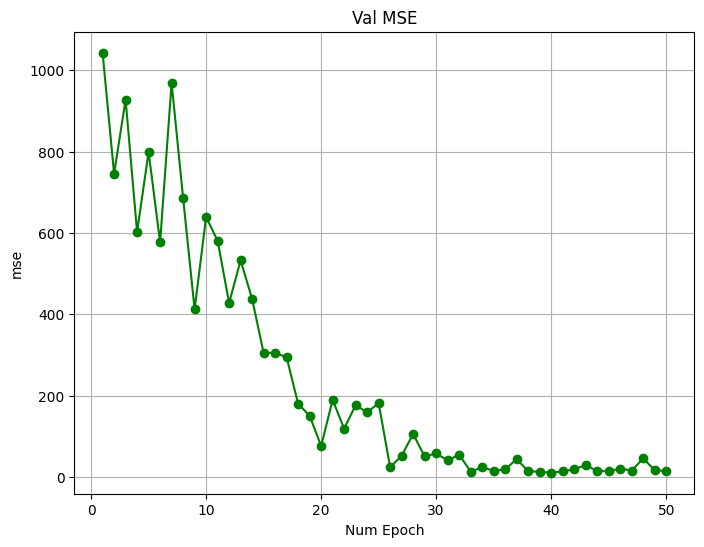

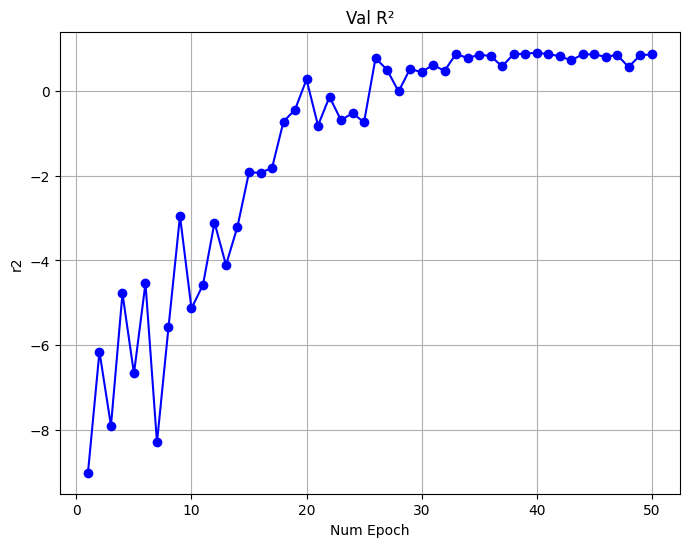

In [13]:
# 如果表现优异，对 tock 进行 train
tock = TimeSeriesTransformer (**best_params_tock)
train_loss, mse_list_train, r2_list_train = tock.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [62.541114807128906, 78.45006561279297, 64.11197662353516, 72.05070495605469]
测试集 R²:  [0.9310371279716492, 0.9099301695823669, 0.9320396780967712, 0.9204685688018799]


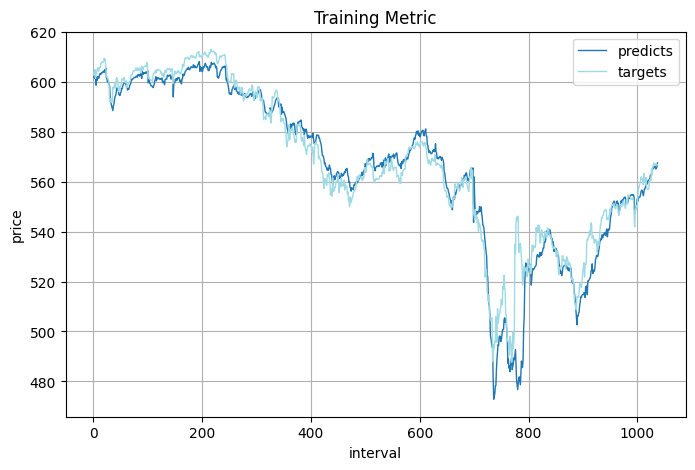

In [15]:
# 对test 进行测试
mse_list_tock, r2_list_tock, preds_tock, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)


print ("测试集 MSE: ", mse_list_tock)
print ("测试集 R²: ", r2_list_tock)

curve_dict = {}
curve_dict['predicts'] = preds_tock[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [17]:
# 网格搜索 LSTM 超参数

init_args_lstm = {
    'input_dim': 49,
    'output_dim': 4,
    'dropout': 0.1
}

param_grid_lstm = {
    'hidden_dim': [64, 128],
    'num_layers': [2, 3],
}

best_params_lstm, best_score_lstm = grid_search (
    TimeSeriesLSTM,
    init_args_lstm,
    sample_dataset(train_dataset, 0.1),
    param_grid=param_grid_lstm,
    cv=3,
    scaler=scaler,
    target_indices=target_indices
)

print ('Best architecture:', best_params_lstm)
print ('Best avg CV MSE:', best_score_lstm)

Testing architecture params: {'hidden_dim': 64, 'num_layers': 2}
Using device: cuda
Using device: cuda
Using device: cuda
 Avg CV MSE: 14.024254, Avg R2: 0.9969370563824972 

Testing architecture params: {'hidden_dim': 64, 'num_layers': 3}
Using device: cuda
Using device: cuda
Using device: cuda
 Avg CV MSE: 18.783952, Avg R2: 0.9959533115228018 

Testing architecture params: {'hidden_dim': 128, 'num_layers': 2}
Using device: cuda
Using device: cuda
Using device: cuda
 Avg CV MSE: 10.915500, Avg R2: 0.9975517690181732 

Testing architecture params: {'hidden_dim': 128, 'num_layers': 3}
Using device: cuda
Using device: cuda
Using device: cuda
 Avg CV MSE: 11.273205, Avg R2: 0.9975234170754751 

Best architecture: {'hidden_dim': 128, 'num_layers': 2}
Best avg CV MSE: 10.915500322977701


In [18]:
# 应用最好的参数, 对全体数据进行 cv，检查performance
# best_params['input_dim'] = init_args['input_dim']
# best_params['output_dim'] = init_args['output_dim']
# best_params['seq_length'] = init_args['seq_length']
# best_params['dropout'] = init_args['dropout']

# 这里为了方便测试，直接使用预先调好的参数
best_params_lstm = {
 'hidden_dim': 128,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 2,
 'dropout': 0.1
 }

best_params_lstm

{'hidden_dim': 128,
 'input_dim': 49,
 'output_dim': 4,
 'num_layers': 2,
 'dropout': 0.1}

Using device: cuda
Epoch 1: reshuffling after 289 bad batches
Epoch 1: reshuffling after 356 bad batches
Epoch 1: reshuffling after 484 bad batches
Epoch 1: reshuffling after 534 bad batches
Epoch 1: reshuffling after 584 bad batches
Epoch 1/100, Loss: 0.014925
Epoch 1/100, Val MSEs: [476.80584716796875, 586.5599975585938, 498.403564453125, 527.153564453125], R²: [-3.591914176940918, -4.787567615509033, -3.655491828918457, -4.054882049560547]
Epoch 2: reshuffling after 95 bad batches
Epoch 2: reshuffling after 158 bad batches
Epoch 2: reshuffling after 208 bad batches
Epoch 2: reshuffling after 258 bad batches
Epoch 2: reshuffling after 308 bad batches
Epoch 2: reshuffling after 358 bad batches
Epoch 2: reshuffling after 408 bad batches
Epoch 2: reshuffling after 458 bad batches
Epoch 2: reshuffling after 508 bad batches
Epoch 2: reshuffling after 558 bad batches
Epoch 2/100, Loss: 0.000174
Epoch 2/100, Val MSEs: [327.7127380371094, 405.35137939453125, 312.66290283203125, 387.770843505

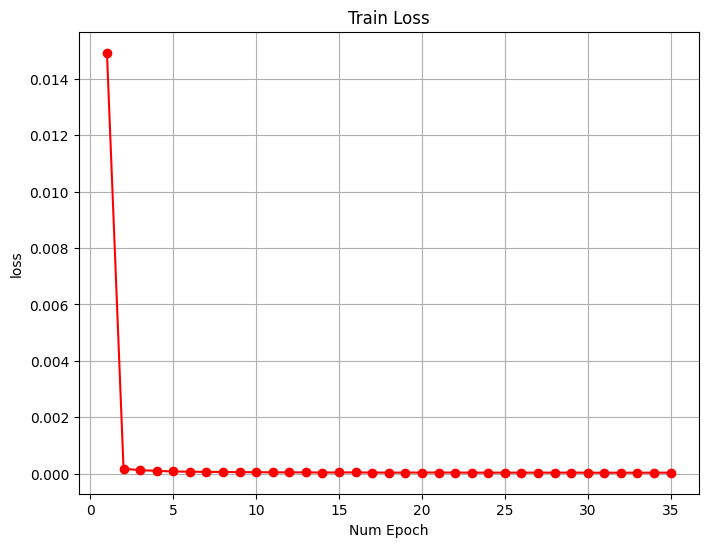

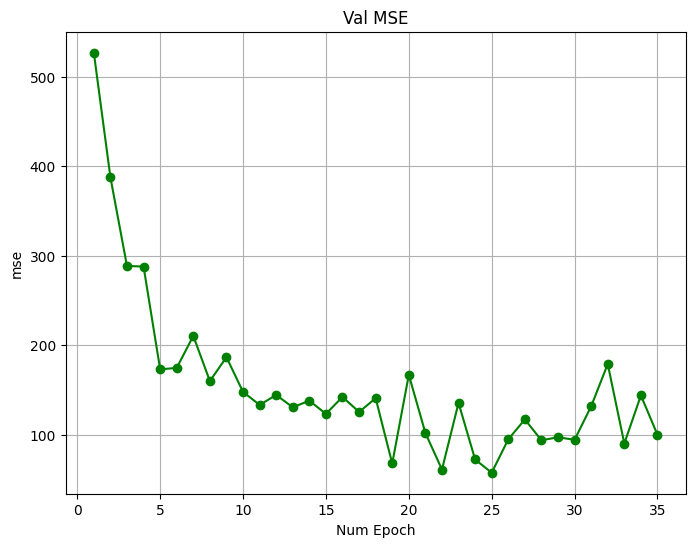

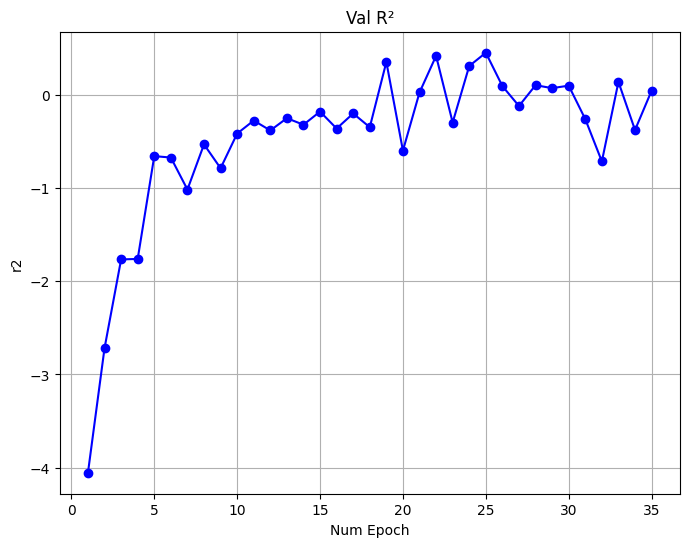

In [19]:
# 如果表现优异，对 lstm 进行 train
lstm = TimeSeriesLSTM (**best_params_lstm)
train_loss, mse_list_train, r2_list_train = lstm.train_model (
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    scaler=scaler,  # 回归任务需要 scaler 进行逆缩放
    target_indices=target_indices,  # 回归任务中目标列索引
    patience=10,
    log=True,
)

# 绘制训练结果
mse_list = np.array (mse_list_train)
r2_list = np.array (r2_list_train)
plot_metric (train_loss, y_label="loss", title="Train Loss", color='red')
plot_metric (mse_list[:, 3], y_label="mse", title="Val MSE", color='green')
plot_metric (r2_list[:, 3], y_label="r2", title="Val R²", color='blue')

测试集 MSE:  [60.11109161376953, 68.61966705322266, 59.265724182128906, 64.04060363769531]
测试集 R²:  [0.9337166547775269, 0.921216607093811, 0.9371768236160278, 0.9293103218078613]


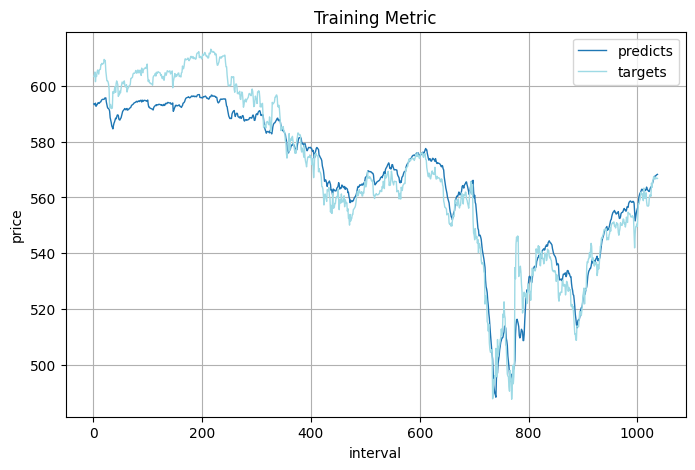

In [20]:
mse_list_lstm, r2_list_lstm, preds_lstm, targets = lstm.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_lstm)
print ("测试集 R²: ", r2_list_lstm)

curve_dict = {}
curve_dict['predicts'] = preds_lstm[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [21]:
# 准备数据集
X_train = train_dataset.tensors[0]
y_train = train_dataset.tensors[1]
X_val = val_dataset.tensors[0]
y_val = val_dataset.tensors[1]
X_test = test_dataset.tensors[0]
y_test = test_dataset.tensors[1]


In [22]:
X_train_rg = X_train.reshape(X_train.shape[0], -1)

X_val_rg = X_val.reshape(X_val.shape[0], -1)

X_test_rg = X_test.reshape(X_test.shape[0], -1)

In [23]:
# 训练 线形模型
ridge = Ridge (alpha=1.0)
ridge.fit (X_train.reshape(X_train.shape[0], -1), y_train)
score_val = ridge.score (X_val.reshape(X_val.shape[0], -1), y_val)
score_test = ridge.score (X_test.reshape(X_test.shape[0], -1), y_test)
print (f"验证集 R²: {score_val:.4f}, 测试集R²:{score_test:.4f}")


验证集 R²: 0.9899, 测试集R²:0.9954


测试集 MSE:  [1.43232456414581, 4.653006969620246, 3.8002827686595575, 6.692748979201162]


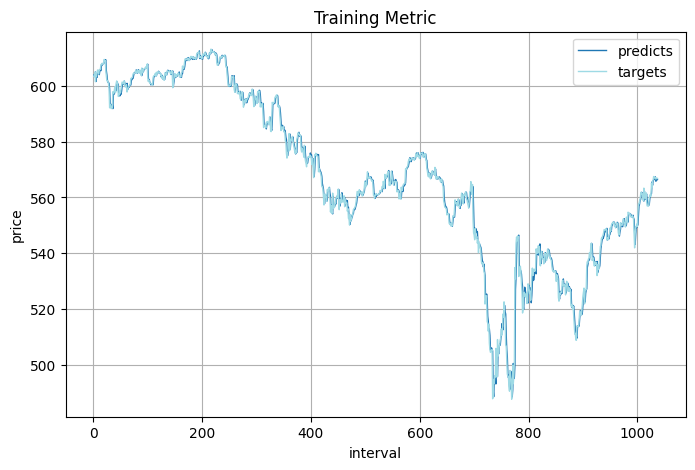

In [24]:
preds_rg = ridge.predict (X_test.reshape(X_test.shape[0], -1))
preds_rg = safe_inverse_transform (preds_rg, scaler, target_indices)

print ("测试集 MSE: ", [mean_squared_error(targets[:, i], preds_rg[:, i]) for i in range(preds_rg.shape[1])])

curve_dict = {}
curve_dict['predicts'] = preds_rg[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [25]:
print (preds_rg[:3])
print (targets[:3])

[[603.96444579 604.60311912 603.52868621 603.94167363]
 [603.2343108  604.24338976 602.44195581 603.30891633]
 [603.90538054 604.96652868 603.03746705 604.16932805]]
[[603.49    603.72003 602.48    603.32   ]
 [603.03    604.0901  602.91    603.98   ]
 [604.11    605.98    603.1     604.94   ]]


In [26]:
# 整理数据
X_val_tock = tock.predict_model (X_val, scaler=scaler, target_indices=target_indices)
X_val_lstm = lstm.predict_model (X_val, scaler=scaler, target_indices=target_indices)

X_val_bd = np.concatenate ((X_val_tock, X_val_lstm), axis=1)
X_val_bd[:3]

array([[585.8982 , 587.3316 , 586.0046 , 586.9526 , 583.401  , 583.19916,
        582.63794, 583.16394],
       [584.1625 , 585.6782 , 584.18036, 585.0876 , 582.3418 , 582.15375,
        581.5603 , 582.07837],
       [584.0846 , 585.75684, 584.2278 , 584.992  , 582.0746 , 581.98535,
        581.3116 , 581.8147 ]], dtype=float32)

In [27]:
# 先用一个简单的线性模型进行 blender
ridge = Ridge (alpha=0.5)
ridge.fit (X_val_bd, y_val)

Ridge(alpha=0.5)

In [28]:
# 预测测试集
X_test_tock = tock.predict_model (X_test, scaler=scaler, target_indices=target_indices)
X_test_lstm = lstm.predict_model (X_test, scaler=scaler, target_indices=target_indices)

X_test_bd = np.concatenate ((X_test_tock, X_test_lstm), axis=1)
X_test_bd[:3]

array([[600.8411 , 602.19507, 600.9344 , 602.0243 , 593.4976 , 593.32404,
        593.0128 , 593.5009 ],
       [600.1272 , 601.49915, 600.1499 , 601.2644 , 593.2237 , 593.0215 ,
        592.7377 , 593.22906],
       [600.49915, 601.8815 , 600.51227, 601.5963 , 593.36584, 593.1805 ,
        592.8898 , 593.3782 ]], dtype=float32)

In [29]:
score = ridge.score (X_test_bd, y_test)
print (f"Test R²: {score:.4f}")
print (f"feature importance:\n {ridge.coef_}")

Test R²: 0.5873
feature importance:
 [[ 1.6677400e-02 -1.1159500e-02  1.2903845e-02 -1.6586648e-02
  -2.6256295e-02  3.0448629e-02 -1.0919953e-03 -1.7616746e-04]
 [ 1.6824601e-02 -9.2191882e-03  9.7373510e-03 -1.5565138e-02
  -2.5485598e-02  3.2366659e-02 -2.5569093e-03 -1.2399106e-03]
 [ 1.6931592e-02 -1.4583146e-02  1.6906824e-02 -1.7356180e-02
  -2.9574368e-02  3.0417643e-02  3.5171330e-04  1.5481401e-03]
 [ 1.6760197e-02 -1.1760648e-02  1.2417479e-02 -1.5565159e-02
  -2.8334850e-02  3.1831250e-02 -6.9037819e-04  8.5656276e-05]]


In [30]:
# 训练blender


blender_params = {
    'base_models': [tock, lstm],  # 基础模型列表
    'output_dim': 4,  # 4个目标值
    'hidden_dims': [16],
    'dropout': 0.1,
}

blender = MLPBlender (**blender_params)

blender.fit (val_dataset,
             val_dataset=test_dataset,
            num_epochs=100,
            batch_size=32,
            lr=1e-4,
            patience=10,
            log=True)

Using device: cuda
Epoch 1: train_loss=0.589245, val_mse=0.488634, val_r2=[-31.049232482910156, -36.2466926574707, -141.48257446289062, -71.12271881103516]
Epoch 2: train_loss=0.553076, val_mse=0.456013, val_r2=[-29.106626510620117, -32.78533935546875, -132.56561279296875, -66.43616485595703]
Epoch 3: train_loss=0.519146, val_mse=0.424859, val_r2=[-26.94603729248047, -29.008676528930664, -125.07585144042969, -61.65949630737305]
Epoch 4: train_loss=0.482473, val_mse=0.395104, val_r2=[-24.373626708984375, -24.96516990661621, -119.05786895751953, -56.85454559326172]
Epoch 5: train_loss=0.449261, val_mse=0.365997, val_r2=[-21.68752670288086, -21.086435317993164, -113.24481201171875, -52.174171447753906]
Epoch 6: train_loss=0.418486, val_mse=0.337595, val_r2=[-19.102718353271484, -17.49609375, -107.36080169677734, -47.60133361816406]
Epoch 7: train_loss=0.383346, val_mse=0.309912, val_r2=[-16.621545791625977, -14.216898918151855, -101.3662109375, -43.16215515136719]
Epoch 8: train_loss=0.35

Blender weights:  {'model_TimeSeriesTransformer': 0.45518264174461365, 'model_TimeSeriesLSTM': 0.5448173880577087}
测试集 MSE:  [209.97789001464844, 98.50434112548828, 132.62738037109375, 194.52163696289062]
测试集 R²:  [0.7684614062309265, 0.8869055509567261, 0.8594116568565369, 0.7852819561958313]


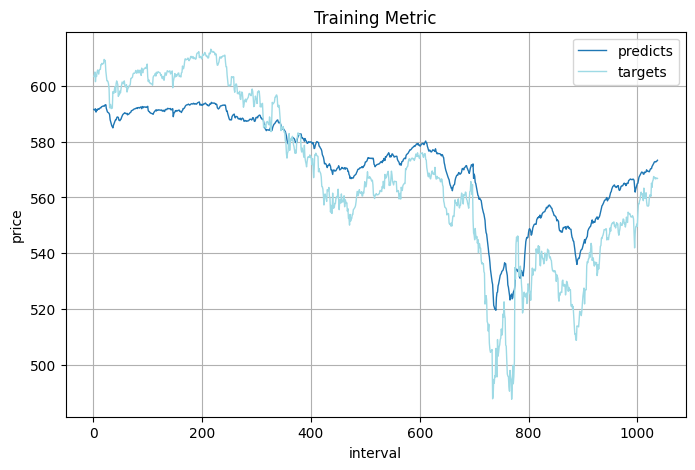

In [31]:
print ("Blender weights: ", blender.get_model_importance ())

mse_list_bd, r2_list_bd, preds_bd, targets = blender.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices)

print ("测试集 MSE: ", mse_list_bd)
print ("测试集 R²: ", r2_list_bd)

curve_dict = {}
curve_dict['predicts'] = preds_bd[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [32]:
# 训练 residual module

from BiasCorrector import BiasCorrector
from sklearn.metrics import mean_squared_error, r2_score


x_tensor = val_dataset.tensors[0]  # 输入特征
y_tensor = val_dataset.tensors[1]  # 对应标签

y = tock.safe_inverse_transform(y_tensor.numpy(), scaler=scaler, target_indices=target_indices)

# 使用 base model 进行预测（注意需要 batch 预测，如果模型较大）
preds_val = tock.predict_model(x_tensor, scaler=scaler, bias_corrector=None, target_indices=target_indices)  # shape: (N, num_targets)


mlp_corrector = BiasCorrector(mode='mean', scale='None')
mlp_corrector.fit(preds_val, y)


AttributeError: 'TimeSeriesTransformer' object has no attribute 'safe_inverse_transform'

In [ ]:
mse_list_cor, r2_list_cor, preds_cor, targets = tock.evaluate_model (test_dataset, batch_size=32,
                                                                         scaler=scaler, target_indices=target_indices,
                                                                        bias_corrector=mlp_corrector)

print ("测试集 MSE: ", mse_list_cor)
print ("测试集 R²: ", r2_list_cor)

curve_dict = {}
curve_dict['predicts'] = preds_cor[:, 3]
curve_dict['targets'] = targets[:, 3]
plot_multiple_curves (curve_dict, x_label='interval', y_label='price')

In [ ]:
# 如果test表现优异，则保存
model_out = "./xxx/xxx/"
scaler_out = "./xxx/xxx/"

os.makedirs (os.path.dirname (model_out), exist_ok=True)
os.makedirs (os.path.dirname (scaler_out), exist_ok=True)
# blender 估计也要保存

print ("=" * 10 + " 保存模型Essentials... " + "=" * 10)
torch.save (model.state_dict (), model_out)
joblib.dump (scaler, scaler_out)